In [1]:
import torch
from torch import nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2

import numpy as np
import os
import pandas as pd

import PIL
from PIL import Image

In [2]:
class EmbeddedImageDataset(VisionDataset):
    
    def __init__(self, roots, transform = None, target_transform = None, train = None):
        super(EmbeddedImageDataset, self).__init__(roots, transform = transform, target_transform = target_transform)
        
        self.roots = roots
        self.train = train
        self.data, self.target = self._load_data()
    
    def _load_data(self):
        data_paths = pd.read_csv(self.roots[2])
        
        data, target1, target2 = [], [], []
        
        if self.train:
            tindex = int(len(data_paths) * 0.8)
            for i in range(tindex):
                mix, pic1, pic2 = data_paths.iloc[i, 1:]
                
                data.append(cv2.cvtColor(cv2.imread(os.path.join(roots[0], mix)), cv2.COLOR_RGB2GRAY))
                target1.append(cv2.cvtColor(cv2.imread(os.path.join(roots[1], pic1)), cv2.COLOR_RGB2GRAY))
                target2.append(cv2.cvtColor(cv2.imread(os.path.join(roots[1], pic2)), cv2.COLOR_RGB2GRAY))

                
        else:
            tindex = int(len(data_paths) * 0.8)
            for i in range(tindex, len(data_paths)):
                mix, pic1, pic2 = data_paths.iloc[i, 1:]
                
                data.append(cv2.cvtColor(cv2.imread(os.path.join(roots[0], mix)), cv2.COLOR_RGB2GRAY))
                target1.append(cv2.cvtColor(cv2.imread(os.path.join(roots[1], pic1)), cv2.COLOR_RGB2GRAY))
                target2.append(cv2.cvtColor(cv2.imread(os.path.join(roots[1], pic2)), cv2.COLOR_RGB2GRAY))
        
        
        
        return data, (target1, target2)
    
    def __getitem__(self, index):
        
        img, target = self.data[index], (self.target[0][index], self.target[1][index])
        
        # print(img.shape, target[0].shape, target[1].shape)
        
        img = Image.fromarray(np.array(img), mode = 'L')
        tgt1 = Image.fromarray(np.array(target[0]), mode = 'L')
        tgt2 = Image.fromarray(np.array(target[1]), mode = 'L')
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            tgt1 = self.target_transform(tgt1)
            tgt2 = self.target_transform(tgt2)
        
        return img, (tgt1, tgt2)
    
    def __len__(self):
        return len(self.data)
        

In [3]:
roots = ['./mixed', './resize/resize_1024', './image_paths.csv']

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_mixed_dataset = EmbeddedImageDataset(roots, transform = transform, target_transform= target_transform, train = True)

In [5]:
batch = 16
trainset = DataLoader(train_mixed_dataset, batch_size = batch, shuffle = True)

In [6]:
def show_images(dataset):
    fig = plt.figure(figsize = (20, 14))
    
    rows = 3
    columns = 4
    
    for i in range(1, columns * rows+1):
        if i >= 1 and i < 5:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i][0].squeeze(0), cmap = 'gray')
        
        if i >= 5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-4][1][0].squeeze(0), cmap = 'gray')
        
        if i >= 9 and i < 13:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-8][1][1].squeeze(0), cmap = 'gray')

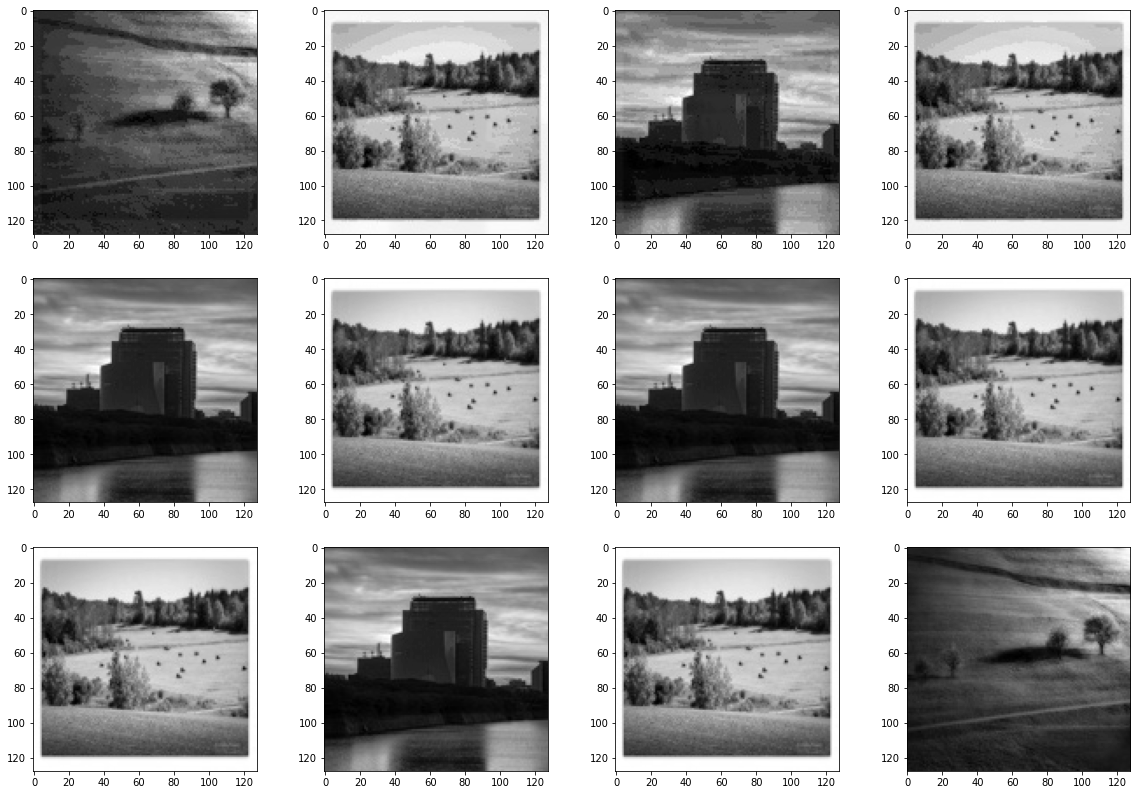

In [7]:
show_images(train_mixed_dataset)

## Building Nueral Network ##

In [8]:
class SeperableConv2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SeperableConv2d, self).__init__()
        self.Depthwise = nn.Conv2d(in_channels, in_channels, kernel_size = kernel_size, padding = 1, groups = in_channels)
        self.Pointwise = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
        
    
    def forward(self, x):
        output = self.Depthwise(x)
        output = self.Pointwise(output)
        
        return output

In [9]:
class AutoEncoder(nn.Module):
    
    def __init__(self, inplace = False):
        super(AutoEncoder, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = (5,5), stride = 1, padding = 2),
            nn.ELU(),
            nn.BatchNorm2d(128, eps = 0.001, momentum = 0.2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), stride = 1, padding = 1, groups = 2),
            nn.ELU(),
            nn.BatchNorm2d(128, eps = 0.001, momentum = 0.2),
            
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), stride = 1, padding = 1, groups = 2),
            nn.ELU(),
            nn.BatchNorm2d(128, eps = 0.001, momentum = 0.2),
        )
        
        self.sep1 = SeperableConv2d(in_channels = 128, out_channels = 128, kernel_size = 3)
        self.sep2 = SeperableConv2d(in_channels = 128, out_channels = 128, kernel_size = 3)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(128, eps= 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3, 3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(64, eps = 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(64, eps = 0.001, momentum = 0.2),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 1, groups = 2),
            nn.ELU(),
            nn.BatchNorm2d(64, eps = 0.001, momentum = 0.2),
            
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride = 1, padding = 1, groups = 2),
            nn.ELU(),
            nn.BatchNorm2d(64, eps = 0.001, momentum = 0.2),
        )
        
        self.sep3 = SeperableConv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.sep4 = SeperableConv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(64, eps= 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (3, 3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(32, eps = 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(32, eps = 0.001, momentum = 0.2),
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(32, eps= 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (3, 3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(16, eps = 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(16, eps = 0.001, momentum = 0.2),
        )
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(16, eps= 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 16, out_channels = 2, kernel_size = (3, 3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(2, eps = 0.001, momentum = 0.2),
            nn.Conv2d(in_channels = 2, out_channels = 2, kernel_size = (3,3), padding = 1, stride = 1),
            nn.ELU(),
            nn.BatchNorm2d(2, eps = 0.001, momentum = 0.2),
            nn.Flatten(start_dim = 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        # print(x.shape),
        output_1 = self.layer1(x)
        
        output = self.layer2[0:2](output_1)
        output = self.sep1(output)
        output = self.layer2[2](output)
        
        output = self.layer2[3:5](output)
        output = self.sep2(output)
        output = self.layer2[5](output)
        
        ## Reducing Gradient Descent by adding Layer 1 and Layer 2
        output = output_1 + output
        
        output_3 = self.layer3(output)
        
        output = self.layer4[0:2](output_3)
        output = self.sep3(output)
        output = self.layer4[2](output)
        
        output = self.layer4[3:5](output)
        output = self.sep4(output)
        output = self.layer4[5](output)
        
        ## Adding layer 4 and layer 3
        output = output_3 + output
        
        output = self.layer5(output)
        output = self.layer6(output)
        output = self.layer7(output)
        
        
        
        # print(output.shape)
        
        
        return output

In [10]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
AEnet = AutoEncoder(inplace = True).cuda()

In [11]:
optimizer = torch.optim.Adam(AEnet.parameters(), lr=0.00001)
criterion = nn.MSELoss()
print(device)

cuda


In [12]:
def train(model, dataset, epochs = 100):
    train_loss = []
    t_loss = []
    flag = True
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataset):
            optimizer.zero_grad()
            outputs = AEnet(data[0].float().to(device))
            output_1 = outputs[:, :16384]
            output_2 = outputs[:, 16384:]
            loss = criterion(output_1.float().to(device), torch.flatten(data[1][0], 1).float().to(device)) + criterion(output_2.float().to(device), torch.flatten(data[1][1], 1).float().to(device))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss per image: %.6f' % (epoch+ 1, i + 1, loss.item()/32))
                t_loss.append(loss.item()/32)
            
    
    print(" The lowest was: ", min(train_loss)/32)
    print("Finished Training")
    return outputs, data, t_loss

In [ ]:
epochs = 25
output, train_data, training_loss = train(AEnet, trainset, epochs = epochs)

[1,   100] loss per image: 0.000682
[1,   200] loss per image: 0.000916
[1,   300] loss per image: 0.000946
[1,   400] loss per image: 0.000769
[2,   100] loss per image: 0.000801
[2,   200] loss per image: 0.000854
[2,   300] loss per image: 0.000714
[2,   400] loss per image: 0.000690
[3,   100] loss per image: 0.000710
[3,   200] loss per image: 0.000860
[3,   300] loss per image: 0.000682
[3,   400] loss per image: 0.000829
[4,   100] loss per image: 0.000782
[4,   200] loss per image: 0.000773
[4,   300] loss per image: 0.000785
[4,   400] loss per image: 0.000751
[5,   100] loss per image: 0.000651
[5,   200] loss per image: 0.000813
[5,   300] loss per image: 0.000862
[5,   400] loss per image: 0.000841
[6,   100] loss per image: 0.000829
[6,   200] loss per image: 0.000904
[6,   300] loss per image: 0.000814
[6,   400] loss per image: 0.000827
[7,   100] loss per image: 0.000910
[7,   200] loss per image: 0.000751
[7,   300] loss per image: 0.000714
[7,   400] loss per image: 0

In [ ]:
def plot_loss(loss, train = True):
    fig = plt.figure(figsize = (10, 7))
    
    if train:
        x = list(np.arange(0.0, float(epochs), 0.25))
        plt.axis("on")
        plt.ylabel("loss")
        plt.xlabel("Epoch")
        plt.title("Training Loss")
        plt.plot(x, loss)
    else:
        x = list(np.arrange(0.0, float(len(loss)), 1.0))
        plt.axis("on")
        plt.ylabel("loss")
        plt.xlabel("Testset")
        plt.title("Testing Loss")
        plt.plot(x, loss)

In [ ]:
plot_loss(training_loss)

In [ ]:
def show_output_images(data, outputs):
    fig = plt.figure(figsize = (30, 21))
    rows = 5
    columns = 4
    j = 0
    for i in range(1, rows * columns + 1):
        if i >= 1 and i < 5:
            fig.add_subplot(rows, columns , i)
            plt.title("Embedded Image")
            plt.imshow(data[0][i].cpu().detach().numpy().reshape(128, 128), cmap = 'gray')
        
        if i >= 5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.title("Data Image 1")
            plt.imshow(data[1][0][i-4].cpu().detach().numpy().reshape(128, 128), cmap = 'gray')
        
        if i >= 9 and i < 13:
            fig.add_subplot(rows, columns, i)
            plt.title("Output Image 1")
            plt.imshow(outputs[i-8][:16384].cpu().detach().numpy().reshape(128, 128), cmap = 'gray')
            
        if i >= 13 and i < 17:
            fig.add_subplot(rows, columns, i)
            plt.title("Data Image 1")
            plt.imshow(data[1][1][i-12].cpu().detach().numpy().reshape(128, 128), cmap = 'gray')
        
        if i>= 17 and i < 21:
            fig.add_subplot(rows, columns, i)
            plt.title("Output Image 2")
            plt.imshow(outputs[i-16][16384:].cpu().detach().numpy().reshape(128, 128), cmap  ='gray')
        

In [ ]:
show_output_images(train_data, output)

# Scratch Space #

In [18]:
# dt = pd.read_csv('./image_paths.csv')

In [19]:
# for i in range(len(dt)):
#     mix, pic1, pic2 = dt.iloc[i, 1:]
#     print(mix, pic1, pic2)
#     break